In [52]:
import random
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_s800_time(names):
    return [ 6.25 * float(el.split('_')[1][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[:,i]) for i in range(sc_data.shape[1])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    plt.scatter(df.iloc[row_num,:], time)
    
def dist(x, y):
    # TODO normed difference
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    
    return (x-y).T@(x-y)


"""
    this implementation of k-means takes as input (i) a matrix pd
    with the data points as rows (ii) an integer K representing the number 
    of clusters, and returns (i) a matrix with the K rows representing 
    the cluster centers 
    """
def k_means_from_pd_data(pd, K, maxIters = 300):
   
    centroids = pd[np.random.choice(pd.shape[0], K, replace=False)]
    old_centroids = centroids.copy()
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([dist(x_i, y_k) for y_k in centroids]) for x_i in pd])
        # Update centroids step
        for k in range(K):
            if (C == k).any():                
                centroids[k] = pd[C == k].mean(axis = 0) 
            else: # if there are no data points assigned to this certain centroid
                centroids[k] = pd[np.random.choice(len(pd))] 
        if np.array_equal(centroids, old_centroids):
            print(f'converged on iter: {i}')
            break
        old_centroids = centroids.copy()
    return C, centroids

def add_top_n_expressed_label_to_var(data,top_n):
    cutoff = sorted(data.var.n_counts, reverse=True)[top_n]

    for i in range(0, data.var.shape[0]):
        if data.var.iloc[i,:].n_counts > cutoff:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = True
        else:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = False
    


In [40]:

s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)

sc.pp.normalize_total(s814_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s814_adata)
sc.pp.filter_genes(s814_adata, min_counts=1)


add_top_n_expressed_label_to_var(s814_adata,50)
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s814_pd = get_periodgram(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])]) 
s814_pd_array = np.array([i[1] for i in s814_pd])
print(len(s814_pd))

50


In [47]:
K = 6
C, centroids = k_means_from_pd_data(s814_pd_array,K)

print('C = \n', C)

converged on iter: 7
C = 
 [3 1 4 1 1 0 0 4 4 1 1 0 0 1 0 5 2 1 3 5 5 0 3 1 4 0 4 5 4 2 4 0 5 4 1 3 4
 1 0 1 1 0 4 0 2 1 1 3 5 3]


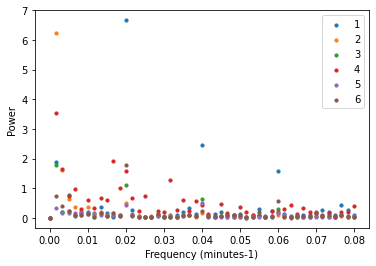

0.01

In [43]:

#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )


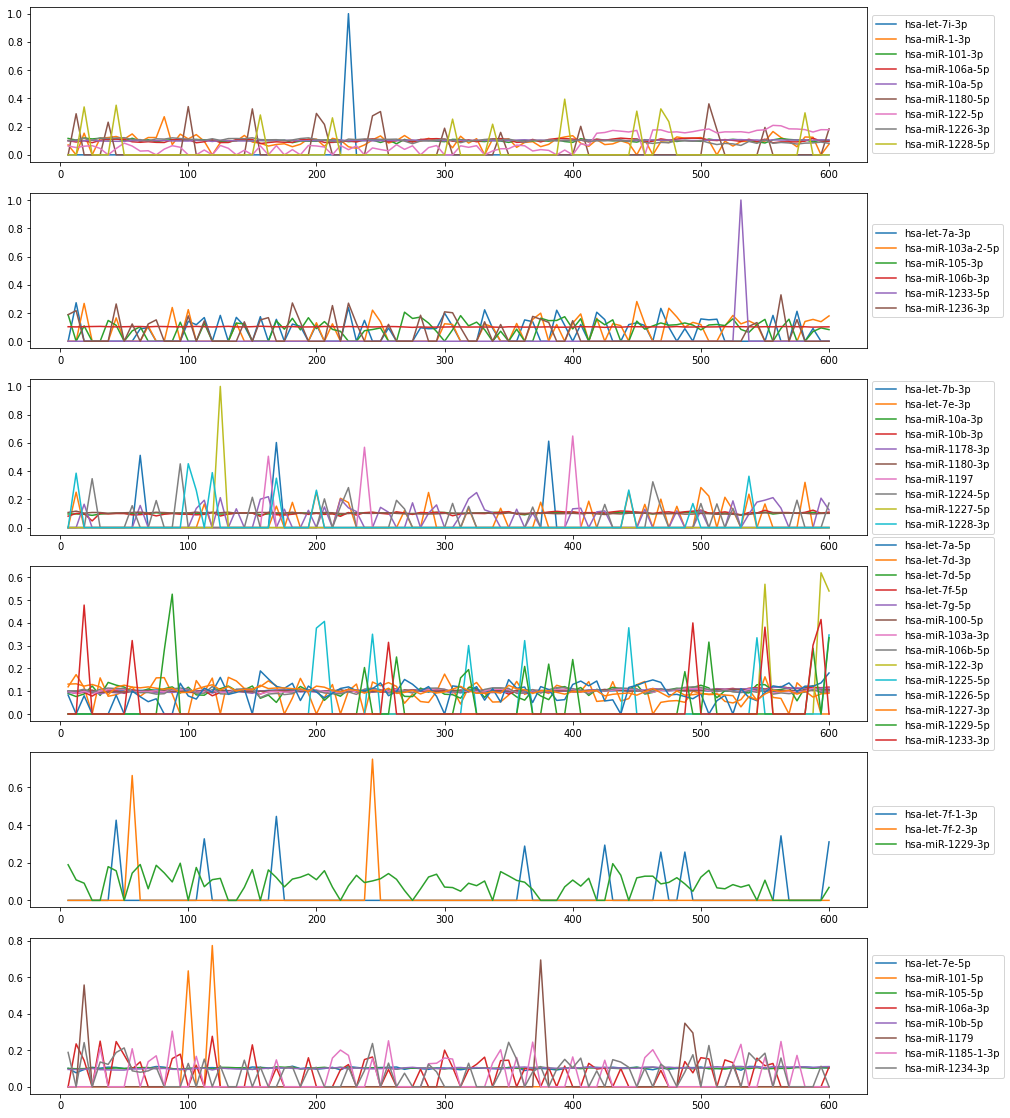

In [46]:

fig, axs = plt.subplots(K,1, figsize=(15,20))

time = s814_adata.obs.time

for i_k in range(K):
    for i in range(len(C)):
        if C[i]==i_k:
            y = s814_adata.X[:,i]
            axs[i_k].plot(time,y/np.linalg.norm(y), label=s814_adata.var.index[i].split(',')[0])
            axs[i_k].legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
#plt.ylabel('Power')

#plt.legend();
#plt.show();

#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

In [54]:
s800_adata = sc.read("data/s800.tab").T

s800_adata.obs['time'] = get_s800_time(s800_adata.obs.index)

sc.pp.normalize_total(s800_adata, target_sum=1e6, exclude_highly_expressed=False)
sc.pp.log1p(s800_adata)
sc.pp.filter_genes(s800_adata, min_counts=1)


add_top_n_expressed_label_to_var(s800_adata,200)
#print(s814_adata[:,1:3])
#print(s814_adata[:,s814_adata.var.top_n_expressed.isin([True])])
#print(type(s814_adata.var.top_n_expressed))

#sc.pp.highly_variable_genes(s814_adata, n_top_genes=100)
#sc.pl.highest_expr_genes(s814_adata, n_top=100, )
s800_pd = get_periodgram(s800_adata[:,s800_adata.var.top_n_expressed.isin([True])]) 
s800_pd_array = np.array([i[1] for i in s800_pd])
print(len(s800_pd))


200


In [66]:
# Find the cluster which has 10-5p guy.
# for each gene in s800_pd, find the distance from pd_gene_i, sort, pick 20 closest.
position_of_10a_5p = list(s814_adata.var.index).index('hsa-miR-10a-5p')
# index in anndata.var means gene names
# but list data type also has a function, called index(), which returns position
Centroid_label_with_10a_5p = C[position_of_10a_5p]
Centroid_values_for_10a_5p = centroids[Centroid_label_with_10a_5p]

print( Centroid_values_for_10a_5p )

#s800.var['dist_to_10a_5p_cluster'] = ... 

[1.49506813e-11 8.74511003e-01 4.66494381e-01 3.12927693e-01
 7.53902420e-02 1.27864972e-01 1.35676816e-01 4.57877740e-02
 1.82601929e-01 5.92443794e-02 1.61235318e-01 7.65729323e-02
 2.21656036e+00 1.06961511e-01 4.95927557e-02 2.03481745e-02
 2.09484752e-02 1.46823302e-01 4.44017723e-02 4.86109592e-02
 2.87877321e-02 1.23122215e-01 1.22448675e-01 6.45642430e-02
 3.81879061e-01 4.86530177e-02 8.64974186e-02 8.85925218e-02
 1.15165718e-01 1.19764656e-01 9.83453989e-02 4.89959568e-02
 1.96202509e-02 2.09105596e-01 4.97850329e-02 8.41796100e-02
 7.19107151e-01 2.12894417e-02 4.00508791e-02 8.03850666e-02
 8.37601349e-02 5.39384224e-02 2.35121295e-01 9.44752246e-02
 1.10309474e-01 2.75591780e-02 1.33972540e-01 8.17496255e-02
 3.54762711e-02]
